<center><h1>Neuroscience Final Project</h1></center>
<center><h2>Deep Q Networks</h2></center>

In this notebook, we are going to get familiar with Deep Q Networks. You have been introduced to Reinforcement Learning in the course. Deep Q Networks are an entension of Reinforcement Learning were we incorporate Deep Neural Networks in our policy enhacement procedure.

We also implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

**Name** : Armin Khosravi

**Student ID**: 401105872

## Importing the necessary packages

In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.cuda.amp import GradScaler, autocast


## Creating the Deep Q Network

In [2]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# class DeepQNetwork(nn.Module):
#     def __init__(self, lr, n_actions, input_dims, fc1_dims, fc2_dims):
#         super(DeepQNetwork, self).__init__()
#         self.input_dims = input_dims
#         self.fc1_dims = fc1_dims
#         self.fc2_dims = fc2_dims
#         self.n_actions = n_actions
# 
#         self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
#         self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
#         self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
# 
#         self.optimizer = optim.Adam(self.parameters(), lr=lr)
#         self.loss = nn.MSELoss()
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
# 
#     def forward(self, state):
#         x = F.relu(self.fc1(state))
#         x = F.relu(self.fc2(x))
#         actions = self.fc3(x)
#         return actions
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims, fc1_dims, fc2_dims, weight_decay=1e-5):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr,
                                    weight_decay=weight_decay)  # Adam optimizer with weight decay
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

# class DeepQNetwork(nn.Module):
#     def __init__(self, lr, n_actions, input_dims, fc1_dims, fc2_dims):
#         super(DeepQNetwork, self).__init__()
#         self.input_dims = input_dims
#         self.fc1_dims = fc1_dims
#         self.fc2_dims = fc2_dims
#         self.n_actions = n_actions
# 
#         # Define fully connected layers
#         self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
#         self.bn1 = nn.BatchNorm1d(self.fc1_dims)
#         self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
#         self.bn2 = nn.BatchNorm1d(self.fc2_dims)
#         self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
# 
#         # Initialize optimizer and loss function
#         self.optimizer = optim.Adam(self.parameters(), lr=lr)  # L2 weight decay
#         self.loss = nn.MSELoss()
# 
#         # Determine device (CPU or GPU)
#         self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
#         self.to(self.device)
# 
#     def forward(self, state):
#         # Forward pass through the network with batch normalization
#         x = F.relu(self.bn1(self.fc1(state)))
#         x = F.relu(self.bn2(self.fc2(x)))
#         actions = self.fc3(x)
#         return actions
# 


## Creating the Agent

this video help me to much for this project
https://www.youtube.com/watch?v=wc-FxNENg9U

In [1]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

        self.scaler = GradScaler()

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation], dtype=T.float32).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch], dtype=T.float32).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch], dtype=T.float32).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch], dtype=T.float32).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch], dtype=T.bool).to(self.Q_eval.device)

        # q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        # q_next = self.Q_eval.forward(new_state_batch)
        # q_next[terminal_batch] = 0.0
        # 
        # q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]
        # 
        # loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        # loss.backward()
        # self.Q_eval.optimizer.step()
        with autocast():
            q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
            q_next = self.Q_eval.forward(new_state_batch)
            q_next[terminal_batch] = 0.0

            q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]

            loss = self.Q_eval.loss(q_target, q_eval)

        self.scaler.scale(loss).backward()
        self.scaler.step(self.Q_eval.optimizer)
        self.scaler.update()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        # Release GPU memory explicitly
        del state_batch, new_state_batch, reward_batch, terminal_batch, q_eval, q_next, q_target
        T.cuda.empty_cache()  # Release all unoccupied cached memory currently held by the caching allocator

## Working with the Maze environment

In [5]:

class MazeEnvironment:
    def __init__(self, dim=100, maze_path=None):
        if maze_path == None:
            boost = np.random.randint(30, 50, [dim, dim]) * np.eye(dim)
            boost[0, 0] = 0
            boost[dim - 1, dim - 1] = 100

            self.maze = np.random.randint(-10, 10, [dim, dim]) + boost
        else:
            self.maze = np.load(maze_path)

        self.x = 0
        self.y = 0
        self.dim = dim
        self.target = [dim - 1, dim - 1]
        self.done = False

    def reset(self):
        self.x = 0
        self.y = 0
        self.done = False
        return np.asarray([self.x, self.y], dtype=np.float32)

    def step(self, action):
        if self.done == True:
            self.reset()

        if action == 0:
            if self.y != 0:
                self.y -= 1
                reward = self.maze[self.x, self.y]
            else:
                reward = 0
        elif action == 1:
            if self.x != (self.dim - 1):
                self.x += 1
                reward = self.maze[self.x, self.y]
            else:
                reward = 0
        elif action == 2:
            if self.y != (self.dim - 1):
                self.y += 1
                reward = self.maze[self.x, self.y]
            else:
                reward = 0
        else:
            if self.x != 0:
                self.x -= 1
                reward = self.maze[self.x, self.y]
            else:
                reward = 0

        if (self.x == (self.dim - 1)) and (self.y == (self.dim - 1)):
            self.done = True

        return np.asarray([self.x, self.y], dtype=np.float32), reward, self.done




In [6]:
# from maze.py import MazeEnvironment
import warnings

warnings.filterwarnings('ignore')

# Create a maze environment
# You can create a new one or use the files stored in directory mazes to load a maze
env = MazeEnvironment(50, 'mazes/maze1.npy')

# def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
#              max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):

agent = Agent(gamma=0.99, epsilon=1.0, batch_size=4, n_actions=4, eps_end=0.2, input_dims=[2], lr=0.001)
scores, eps_history = [], []
n_games = 50

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    counter = 0
    while not done:
        counter += 1
        # If performed 1000 moves and didn't finish the maze, reset the environment
        if (counter == 1000):
            break

        # Make the agent choose an action
        action = agent.choose_action(observation)

        # Retrieve the reward and next_state from the envirinment
        observation_, reward, done = env.step(action)

        score += reward

        # Store the current episode in the memory
        agent.store_transition(observation, action, reward, observation_, done)

        # Learn the current episode
        agent.learn()

        # Change the next state to the current state
        observation = observation_

    scores.append(score)

    avg_score = np.mean(scores[-100:])

    print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

episode  0 score 2828.00 average score 2828.00 epsilon 0.50
episode  1 score 984.00 average score 1906.00 epsilon 0.20
episode  2 score 1003.00 average score 1605.00 epsilon 0.20
episode  3 score 1016.00 average score 1457.75 epsilon 0.20
episode  4 score 3517.00 average score 1869.60 epsilon 0.20
episode  5 score 3455.00 average score 2133.83 epsilon 0.20
episode  6 score 1352.00 average score 2022.14 epsilon 0.20
episode  7 score 2963.00 average score 2139.75 epsilon 0.20
episode  8 score 3861.00 average score 2331.00 epsilon 0.20
episode  9 score 4002.00 average score 2498.10 epsilon 0.20
episode  10 score 757.00 average score 2339.82 epsilon 0.20
episode  11 score 2516.00 average score 2354.50 epsilon 0.20
episode  12 score 2294.00 average score 2349.85 epsilon 0.20
episode  13 score 5127.00 average score 2548.21 epsilon 0.20
episode  14 score 8253.00 average score 2928.53 epsilon 0.20
episode  15 score 5045.00 average score 3060.81 epsilon 0.20
episode  16 score 3318.00 average sc

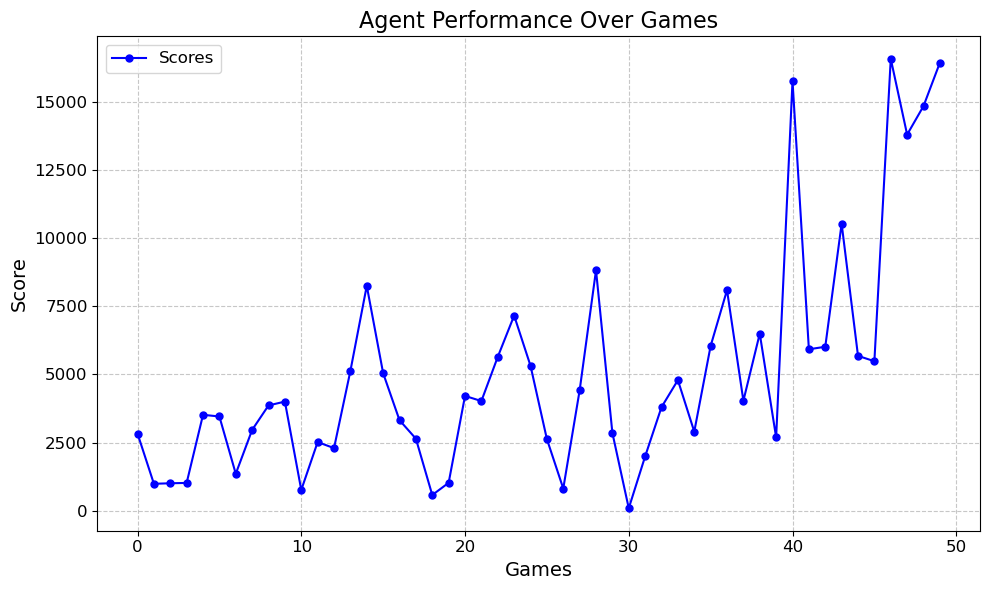

In [7]:

import matplotlib.pyplot as plt

# Plotting with enhanced appearance


plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.plot(range(n_games), scores, color='b', linestyle='-', marker='o', markersize=5, label='Scores')
plt.xlabel('Games', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Agent Performance Over Games', fontsize=16)
plt.legend(loc='upper left', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines with transparency

# Customize tick marks
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.tight_layout()  # Improve spacing between subplots and around the plot

plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


def run_experiment(env_path, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                   max_mem_size, eps_end, eps_dec, n_games):
    # Create the maze environment
    env = MazeEnvironment(50, env_path)

    # Initialize the agent
    agent = Agent(gamma=gamma, epsilon=epsilon, lr=lr, input_dims=input_dims,
                  batch_size=batch_size, n_actions=n_actions, max_mem_size=max_mem_size,
                  eps_end=eps_end, eps_dec=eps_dec)

    scores, eps_history = [], []

    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        counter = 0
        while not done:
            counter += 1
            # If performed 1000 moves and didn't finish the maze, reset the environment
            if counter == 1000:
                break

            # Make the agent choose an action
            action = agent.choose_action(observation)

            # Retrieve the reward and next_state from the environment
            observation_, reward, done = env.step(action)

            score += reward

            # Store the current episode in the memory
            agent.store_transition(observation, action, reward, observation_, done)

            # Learn the current episode
            agent.learn()

            # Change the next state to the current state
            observation = observation_

        scores.append(score)

        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

    plot_scores(scores, n_games)


def plot_scores(scores, n_games):
    plt.figure(figsize=(10, 6))  # Adjust the figure size

    plt.plot(range(n_games), scores, color='b', linestyle='-', marker='o', markersize=5, label='Scores')
    plt.xlabel('Games', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Agent Performance Over Games', fontsize=16)
    plt.legend(loc='upper left', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines with transparency

    # Customize tick marks
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)

    plt.tight_layout()  # Improve spacing between subplots and around the plot

    plt.show()




episode  0 score 899.00 average score 899.00 epsilon 0.90
episode  1 score 245.00 average score 572.00 epsilon 0.80
episode  2 score 1317.00 average score 820.33 epsilon 0.70
episode  3 score 3490.00 average score 1487.75 epsilon 0.60
episode  4 score 4246.00 average score 2039.40 epsilon 0.50
episode  5 score 2603.00 average score 2133.33 epsilon 0.46
episode  6 score 7264.00 average score 2866.29 epsilon 0.40
episode  7 score 120.00 average score 2523.00 epsilon 0.40
episode  8 score 545.00 average score 2303.22 epsilon 0.40
episode  9 score 1471.00 average score 2220.00 epsilon 0.40
episode  10 score 4725.00 average score 2447.73 epsilon 0.40
episode  11 score 552.00 average score 2289.75 epsilon 0.40
episode  12 score 1993.00 average score 2266.92 epsilon 0.40
episode  13 score 2873.00 average score 2310.21 epsilon 0.40
episode  14 score 4567.00 average score 2460.67 epsilon 0.40
episode  15 score 8168.00 average score 2817.38 epsilon 0.40
episode  16 score 3530.00 average score 28

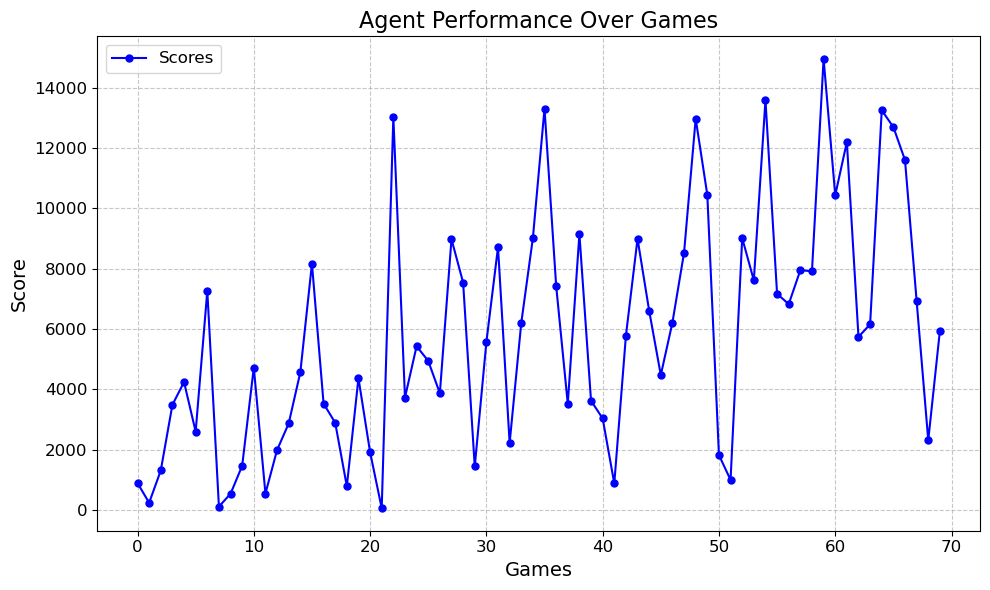

In [12]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.99,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=4,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.4,
    eps_dec=1e-4,
    n_games=70
)

episode  0 score 134.00 average score 134.00 epsilon 0.99
episode  1 score 922.00 average score 528.00 epsilon 0.98
episode  2 score 3381.00 average score 1479.00 epsilon 0.97
episode  3 score 296.00 average score 1183.25 epsilon 0.96
episode  4 score 1550.00 average score 1256.60 epsilon 0.95
episode  5 score 1235.00 average score 1253.00 epsilon 0.94
episode  6 score 191.00 average score 1101.29 epsilon 0.93
episode  7 score 2007.00 average score 1214.50 epsilon 0.92
episode  8 score 1517.00 average score 1248.11 epsilon 0.91
episode  9 score 2220.00 average score 1345.30 epsilon 0.90
episode  10 score 3466.00 average score 1538.09 epsilon 0.89
episode  11 score 3727.00 average score 1720.50 epsilon 0.88
episode  12 score 3568.00 average score 1862.62 epsilon 0.87
episode  13 score 4635.00 average score 2060.64 epsilon 0.86
episode  14 score 4397.00 average score 2216.40 epsilon 0.85
episode  15 score 3829.00 average score 2317.19 epsilon 0.85
episode  16 score 4917.00 average score 

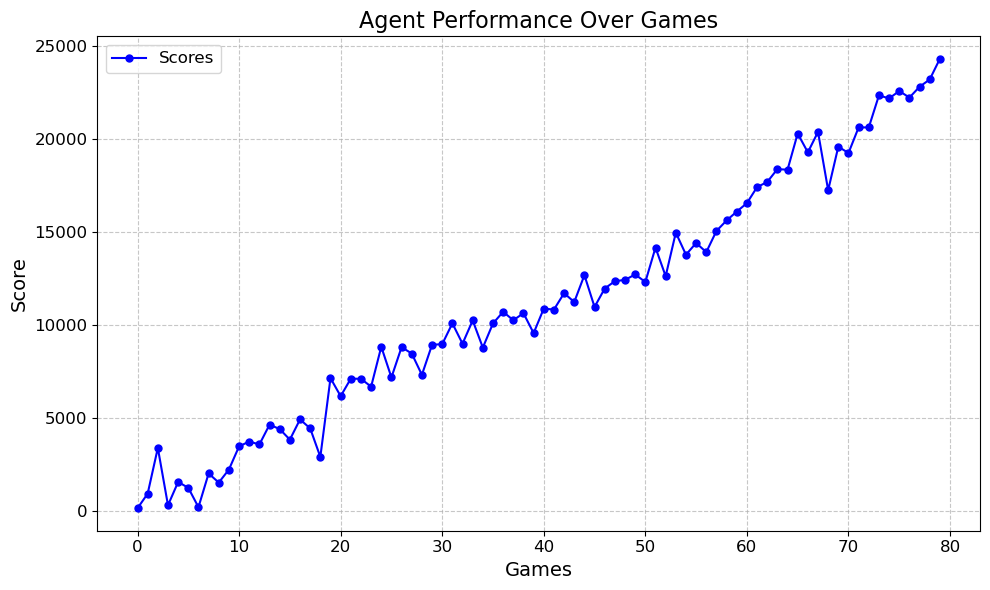

In [13]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.95,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=80
)

episode  0 score -534.00 average score -534.00 epsilon 0.90
episode  1 score 2266.00 average score 866.00 epsilon 0.80
episode  2 score 4309.00 average score 2013.67 epsilon 0.72
episode  3 score 4814.00 average score 2713.75 epsilon 0.66
episode  4 score 6292.00 average score 3429.40 epsilon 0.59
episode  5 score 4418.00 average score 3594.17 epsilon 0.55
episode  6 score 3602.00 average score 3595.29 epsilon 0.52
episode  7 score 7570.00 average score 4092.12 epsilon 0.47
episode  8 score 5272.00 average score 4223.22 epsilon 0.43
episode  9 score 6434.00 average score 4444.30 epsilon 0.40
episode  10 score 11132.00 average score 5052.27 epsilon 0.40
episode  11 score 14701.00 average score 5856.33 epsilon 0.40
episode  12 score 14867.00 average score 6549.46 epsilon 0.40
episode  13 score 13851.00 average score 7071.00 epsilon 0.40
episode  14 score 15452.00 average score 7629.73 epsilon 0.40
episode  15 score 16035.00 average score 8155.06 epsilon 0.40
episode  16 score 16142.00 av

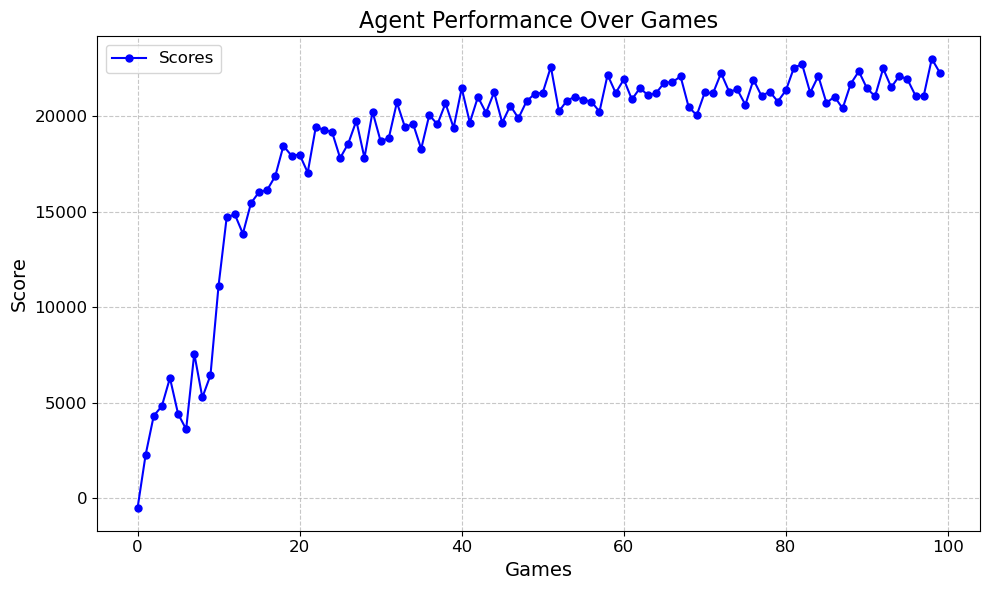

In [14]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.4,
    eps_dec=1e-4,
    n_games=100
)

episode  0 score 758.00 average score 758.00 epsilon 0.99
episode  1 score -111.00 average score 323.50 epsilon 0.98
episode  2 score -435.00 average score 70.67 epsilon 0.97
episode  3 score 2534.00 average score 686.50 epsilon 0.96
episode  4 score 448.00 average score 638.80 epsilon 0.95
episode  5 score 1844.00 average score 839.67 epsilon 0.94
episode  6 score 2938.00 average score 1139.43 epsilon 0.93
episode  7 score 2793.00 average score 1346.12 epsilon 0.92
episode  8 score 2169.00 average score 1437.56 epsilon 0.91
episode  9 score 2338.00 average score 1527.60 epsilon 0.90
episode  10 score 1830.00 average score 1555.09 epsilon 0.89
episode  11 score 3103.00 average score 1684.08 epsilon 0.88
episode  12 score 4040.00 average score 1865.31 epsilon 0.87
episode  13 score 3886.00 average score 2009.64 epsilon 0.86
episode  14 score 5740.00 average score 2258.33 epsilon 0.85
episode  15 score 4931.00 average score 2425.38 epsilon 0.84
episode  16 score 6626.00 average score 267

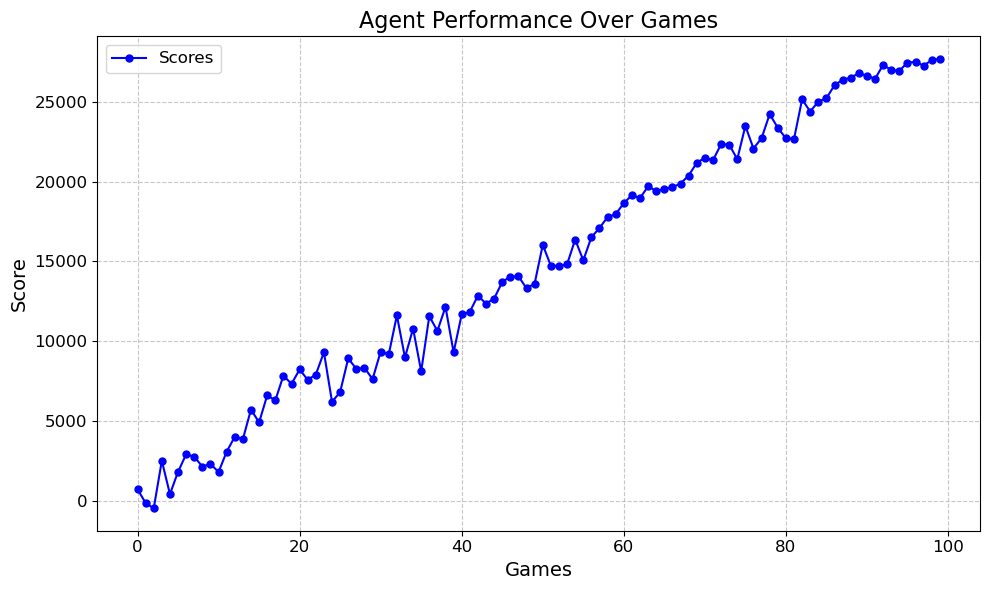

In [15]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.95,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 1404.00 average score 1404.00 epsilon 0.99
episode  1 score 244.00 average score 824.00 epsilon 0.98
episode  2 score 2726.00 average score 1458.00 epsilon 0.97
episode  3 score 2532.00 average score 1726.50 epsilon 0.96
episode  4 score 802.00 average score 1541.60 epsilon 0.95
episode  5 score 2426.00 average score 1689.00 epsilon 0.94
episode  6 score 1202.00 average score 1619.43 epsilon 0.93
episode  7 score 3070.00 average score 1800.75 epsilon 0.92
episode  8 score 3314.00 average score 1968.89 epsilon 0.91
episode  9 score 4151.00 average score 2187.10 epsilon 0.90
episode  10 score 1604.00 average score 2134.09 epsilon 0.89
episode  11 score 5380.00 average score 2404.58 epsilon 0.88
episode  12 score 5160.00 average score 2616.54 epsilon 0.87
episode  13 score 4469.00 average score 2748.86 epsilon 0.86
episode  14 score 3753.00 average score 2815.80 epsilon 0.85
episode  15 score 3823.00 average score 2878.75 epsilon 0.84
episode  16 score 5763.00 average sco

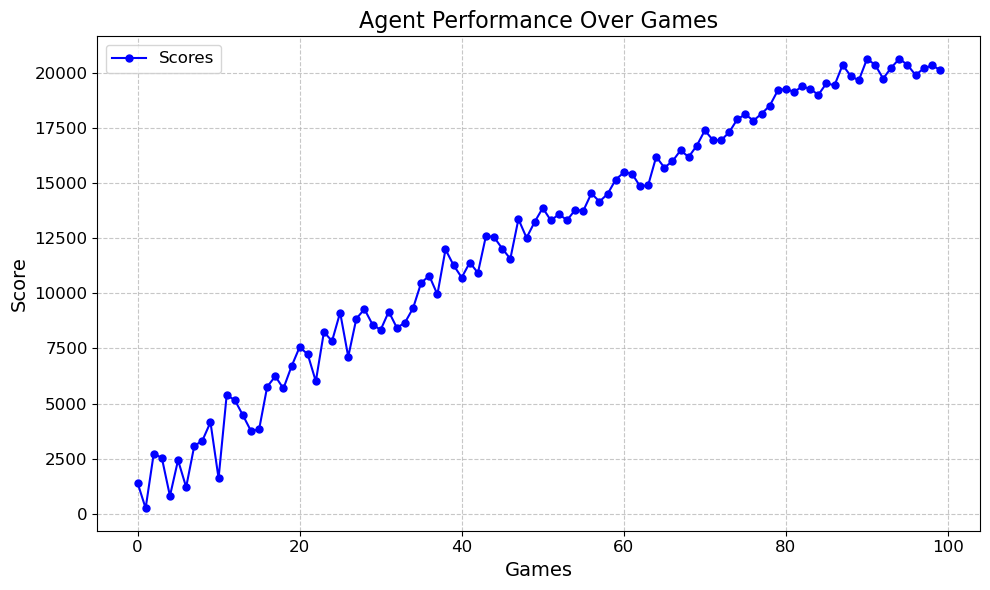

In [16]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.95,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=16,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 774.00 average score 774.00 epsilon 0.99
episode  1 score 543.00 average score 658.50 epsilon 0.98
episode  2 score 480.00 average score 599.00 epsilon 0.97
episode  3 score 1050.00 average score 711.75 epsilon 0.96
episode  4 score 2671.00 average score 1103.60 epsilon 0.95
episode  5 score 2921.00 average score 1406.50 epsilon 0.94
episode  6 score 2992.00 average score 1633.00 epsilon 0.93
episode  7 score 3488.00 average score 1864.88 epsilon 0.92
episode  8 score 3514.00 average score 2048.11 epsilon 0.91
episode  9 score 1759.00 average score 2019.20 epsilon 0.91
episode  10 score 4594.00 average score 2253.27 epsilon 0.90
episode  11 score 4541.00 average score 2443.92 epsilon 0.89
episode  12 score 5994.00 average score 2717.00 epsilon 0.88
episode  13 score 5133.00 average score 2889.57 epsilon 0.87
episode  14 score 6787.00 average score 3149.40 epsilon 0.86
episode  15 score 4892.00 average score 3258.31 epsilon 0.85
episode  16 score 4928.00 average score 3

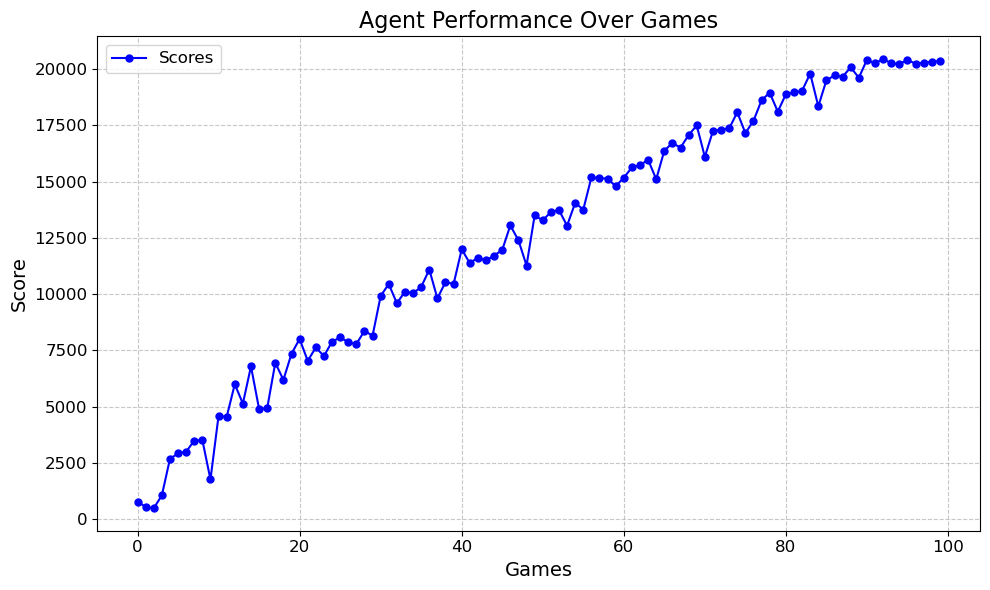

In [17]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.95,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=32,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 2706.00 average score 2706.00 epsilon 0.99
episode  1 score 1395.00 average score 2050.50 epsilon 0.98
episode  2 score 1609.00 average score 1903.33 epsilon 0.97
episode  3 score 854.00 average score 1641.00 epsilon 0.96
episode  4 score 2235.00 average score 1759.80 epsilon 0.95
episode  5 score 4470.00 average score 2211.50 epsilon 0.94
episode  6 score 3329.00 average score 2371.14 epsilon 0.93
episode  7 score 2593.00 average score 2398.88 epsilon 0.92
episode  8 score 5572.00 average score 2751.44 epsilon 0.91
episode  9 score 2721.00 average score 2748.40 epsilon 0.90
episode  10 score 6093.00 average score 3052.45 epsilon 0.89
episode  11 score 6891.00 average score 3372.33 epsilon 0.88
episode  12 score 4641.00 average score 3469.92 epsilon 0.87
episode  13 score 4003.00 average score 3508.00 epsilon 0.86
episode  14 score 5546.00 average score 3643.87 epsilon 0.85
episode  15 score 4403.00 average score 3691.31 epsilon 0.84
episode  16 score 5677.00 average s

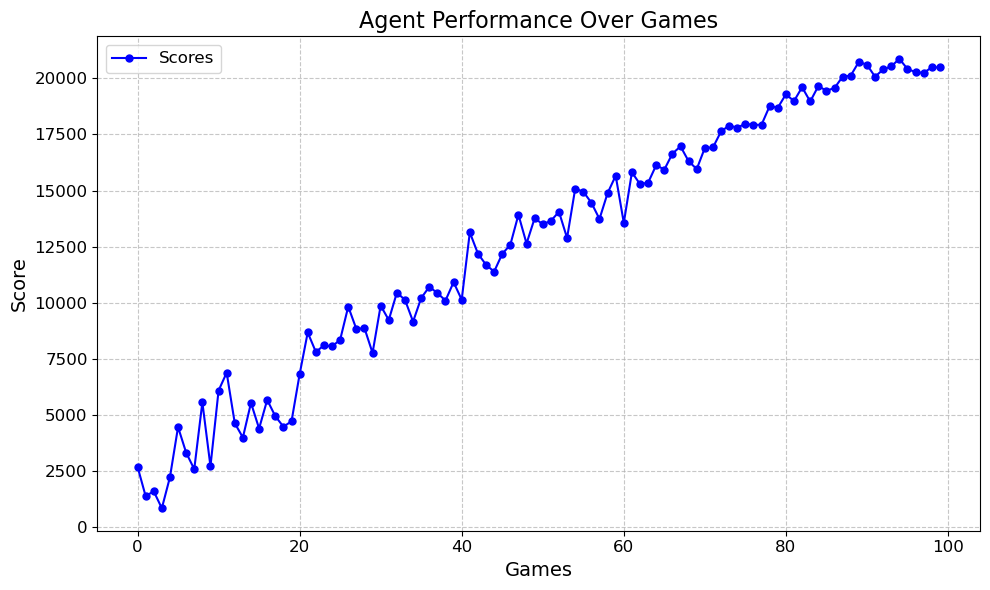

In [18]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.95,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=64,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 132.00 average score 132.00 epsilon 0.99
episode  1 score 1294.00 average score 713.00 epsilon 0.98
episode  2 score 1881.00 average score 1102.33 epsilon 0.97
episode  3 score 1804.00 average score 1277.75 epsilon 0.96
episode  4 score 4633.00 average score 1948.80 epsilon 0.95
episode  5 score 1372.00 average score 1852.67 epsilon 0.94
episode  6 score 802.00 average score 1702.57 epsilon 0.93
episode  7 score 479.00 average score 1549.62 epsilon 0.92
episode  8 score 3271.00 average score 1740.89 epsilon 0.91
episode  9 score 872.00 average score 1654.00 epsilon 0.90
episode  10 score 2783.00 average score 1756.64 epsilon 0.89
episode  11 score 4292.00 average score 1967.92 epsilon 0.88
episode  12 score 3322.00 average score 2072.08 epsilon 0.87
episode  13 score 6184.00 average score 2365.79 epsilon 0.86
episode  14 score 6023.00 average score 2609.60 epsilon 0.85
episode  15 score 4478.00 average score 2726.38 epsilon 0.84
episode  16 score 4834.00 average score 

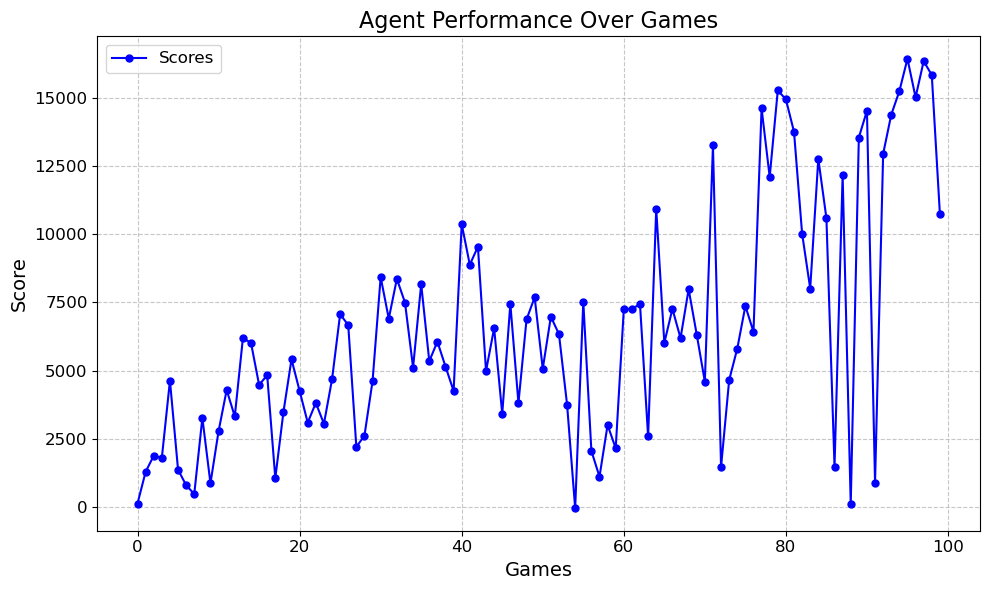

In [19]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.99,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 1276.00 average score 1276.00 epsilon 0.99
episode  1 score 453.00 average score 864.50 epsilon 0.98
episode  2 score 1170.00 average score 966.33 epsilon 0.97
episode  3 score 1364.00 average score 1065.75 epsilon 0.96
episode  4 score 3312.00 average score 1515.00 epsilon 0.95
episode  5 score 1226.00 average score 1466.83 epsilon 0.94
episode  6 score 3601.00 average score 1771.71 epsilon 0.93
episode  7 score 3065.00 average score 1933.38 epsilon 0.92
episode  8 score 5217.00 average score 2298.22 epsilon 0.91
episode  9 score 5078.00 average score 2576.20 epsilon 0.90
episode  10 score 4781.00 average score 2776.64 epsilon 0.89
episode  11 score 1962.00 average score 2708.75 epsilon 0.88
episode  12 score 2954.00 average score 2727.62 epsilon 0.87
episode  13 score 3099.00 average score 2754.14 epsilon 0.86
episode  14 score 6164.00 average score 2981.47 epsilon 0.85
episode  15 score 6621.00 average score 3208.94 epsilon 0.84
episode  16 score 6147.00 average sco

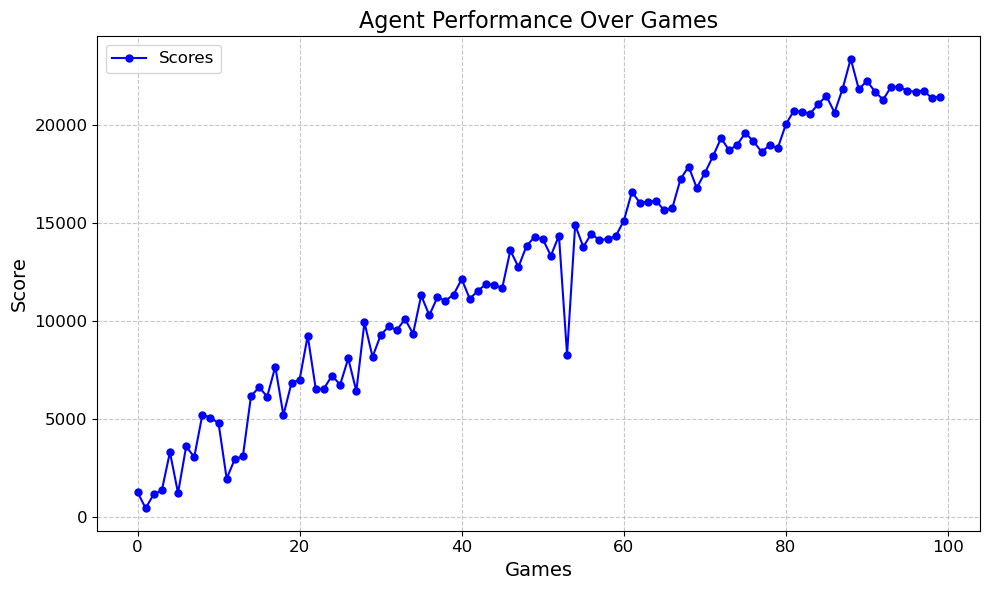

In [20]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.85,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 1977.00 average score 1977.00 epsilon 0.99
episode  1 score 359.00 average score 1168.00 epsilon 0.98
episode  2 score -10.00 average score 775.33 epsilon 0.97
episode  3 score 1440.00 average score 941.50 epsilon 0.96
episode  4 score -97.00 average score 733.80 epsilon 0.95
episode  5 score 630.00 average score 716.50 epsilon 0.94
episode  6 score 2158.00 average score 922.43 epsilon 0.93
episode  7 score 1688.00 average score 1018.12 epsilon 0.92
episode  8 score 4854.00 average score 1444.33 epsilon 0.91
episode  9 score 2793.00 average score 1579.20 epsilon 0.90
episode  10 score 2702.00 average score 1681.27 epsilon 0.89
episode  11 score 2306.00 average score 1733.33 epsilon 0.88
episode  12 score 4698.00 average score 1961.38 epsilon 0.87
episode  13 score 2988.00 average score 2034.71 epsilon 0.86
episode  14 score 5374.00 average score 2257.33 epsilon 0.85
episode  15 score 5608.00 average score 2466.75 epsilon 0.84
episode  16 score 7639.00 average score 277

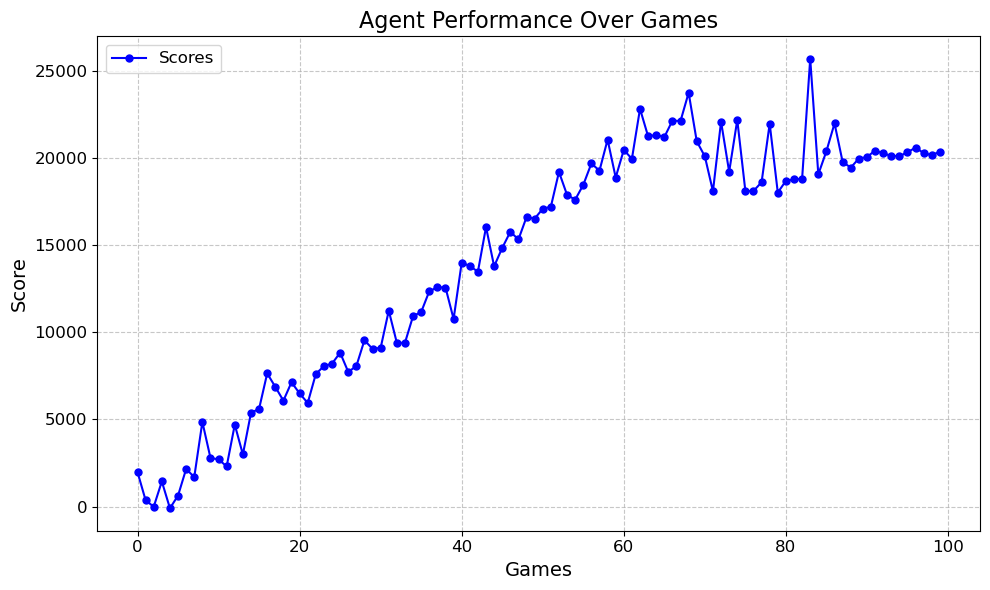

In [21]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.7,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 906.00 average score 906.00 epsilon 0.99
episode  1 score 376.00 average score 641.00 epsilon 0.98
episode  2 score 2092.00 average score 1124.67 epsilon 0.97
episode  3 score 1570.00 average score 1236.00 epsilon 0.96
episode  4 score 4108.00 average score 1810.40 epsilon 0.95
episode  5 score 1681.00 average score 1788.83 epsilon 0.94
episode  6 score 2046.00 average score 1825.57 epsilon 0.93
episode  7 score 2511.00 average score 1911.25 epsilon 0.92
episode  8 score 3149.00 average score 2048.78 epsilon 0.91
episode  9 score 5032.00 average score 2347.10 epsilon 0.90
episode  10 score 3419.00 average score 2444.55 epsilon 0.89
episode  11 score 2754.00 average score 2470.33 epsilon 0.88
episode  12 score 3292.00 average score 2533.54 epsilon 0.87
episode  13 score 1653.00 average score 2470.64 epsilon 0.86
episode  14 score 4769.00 average score 2623.87 epsilon 0.85
episode  15 score 5339.00 average score 2793.56 epsilon 0.84
episode  16 score 4860.00 average scor

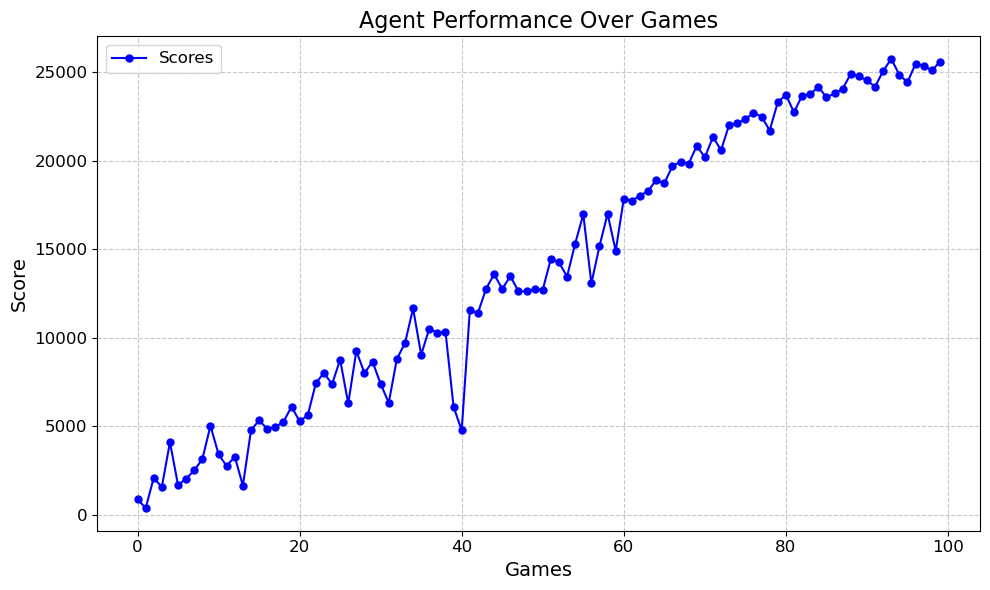

In [22]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 2626.00 average score 2626.00 epsilon 0.99
episode  1 score 983.00 average score 1804.50 epsilon 0.98
episode  2 score 1005.00 average score 1538.00 epsilon 0.97
episode  3 score 2226.00 average score 1710.00 epsilon 0.96
episode  4 score 1437.00 average score 1655.40 epsilon 0.95
episode  5 score 3837.00 average score 2019.00 epsilon 0.94
episode  6 score 2323.00 average score 2062.43 epsilon 0.93
episode  7 score 1656.00 average score 2011.62 epsilon 0.92
episode  8 score 3470.00 average score 2173.67 epsilon 0.91
episode  9 score 3774.00 average score 2333.70 epsilon 0.90
episode  10 score 4712.00 average score 2549.91 epsilon 0.89
episode  11 score 4104.00 average score 2679.42 epsilon 0.88
episode  12 score 6529.00 average score 2975.54 epsilon 0.87
episode  13 score 3757.00 average score 3031.36 epsilon 0.86
episode  14 score 4283.00 average score 3114.80 epsilon 0.85
episode  15 score 4865.00 average score 3224.19 epsilon 0.84
episode  16 score 5437.00 average s

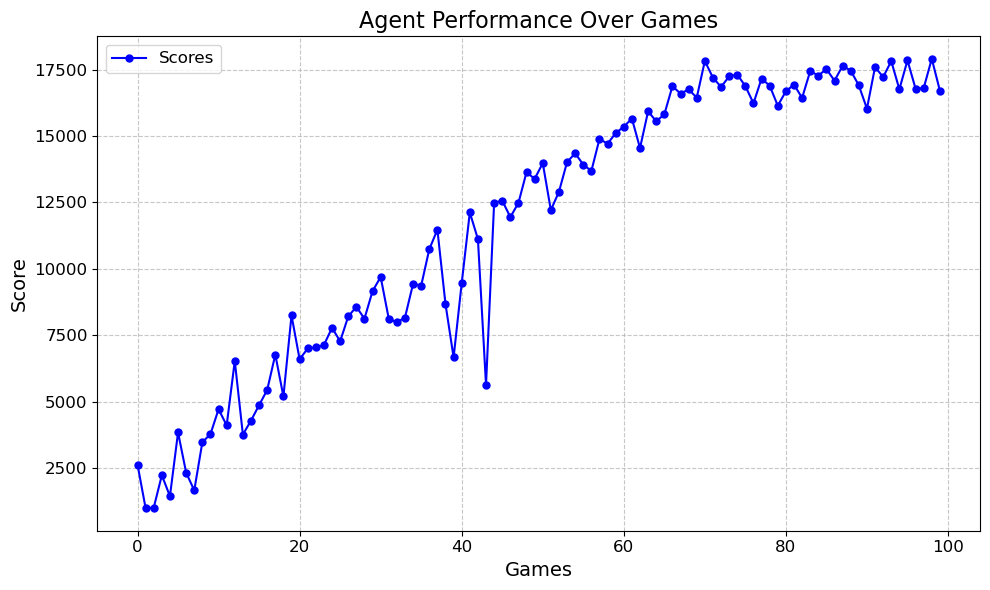

In [23]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.3,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 2040.00 average score 2040.00 epsilon 0.99
episode  1 score 667.00 average score 1353.50 epsilon 0.98
episode  2 score 321.00 average score 1009.33 epsilon 0.97
episode  3 score 2123.00 average score 1287.75 epsilon 0.96
episode  4 score 1838.00 average score 1397.80 epsilon 0.95
episode  5 score 1885.00 average score 1479.00 epsilon 0.94
episode  6 score 1543.00 average score 1488.14 epsilon 0.93
episode  7 score 3974.00 average score 1798.88 epsilon 0.92
episode  8 score 3368.00 average score 1973.22 epsilon 0.91
episode  9 score 5282.00 average score 2304.10 epsilon 0.90
episode  10 score 2430.00 average score 2315.55 epsilon 0.89
episode  11 score 4946.00 average score 2534.75 epsilon 0.88
episode  12 score 4768.00 average score 2706.54 epsilon 0.87
episode  13 score 4477.00 average score 2833.00 epsilon 0.86
episode  14 score 5245.00 average score 2993.80 epsilon 0.85
episode  15 score 4737.00 average score 3102.75 epsilon 0.84
episode  16 score 6444.00 average sc

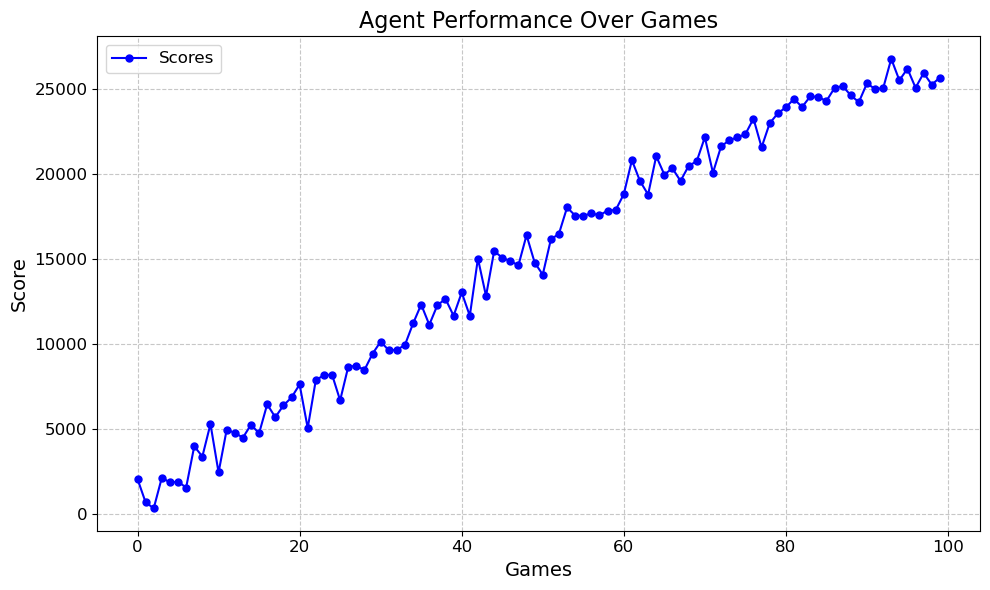

In [24]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.002,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=1e-5,
    n_games=100
)

episode  0 score 946.00 average score 946.00 epsilon 0.99
episode  1 score 549.00 average score 747.50 epsilon 0.98
episode  2 score 4301.00 average score 1932.00 epsilon 0.97
episode  3 score 1693.00 average score 1872.25 epsilon 0.96
episode  4 score 2900.00 average score 2077.80 epsilon 0.95
episode  5 score 284.00 average score 1778.83 epsilon 0.94
episode  6 score 4400.00 average score 2153.29 epsilon 0.93
episode  7 score 1832.00 average score 2113.12 epsilon 0.92
episode  8 score 4333.00 average score 2359.78 epsilon 0.91
episode  9 score 3544.00 average score 2478.20 epsilon 0.90
episode  10 score 4639.00 average score 2674.64 epsilon 0.89
episode  11 score 4493.00 average score 2826.17 epsilon 0.88
episode  12 score 4132.00 average score 2926.62 epsilon 0.87
episode  13 score 4796.00 average score 3060.14 epsilon 0.86
episode  14 score 4997.00 average score 3189.27 epsilon 0.85
episode  15 score 5053.00 average score 3305.75 epsilon 0.84
episode  16 score 5262.00 average score

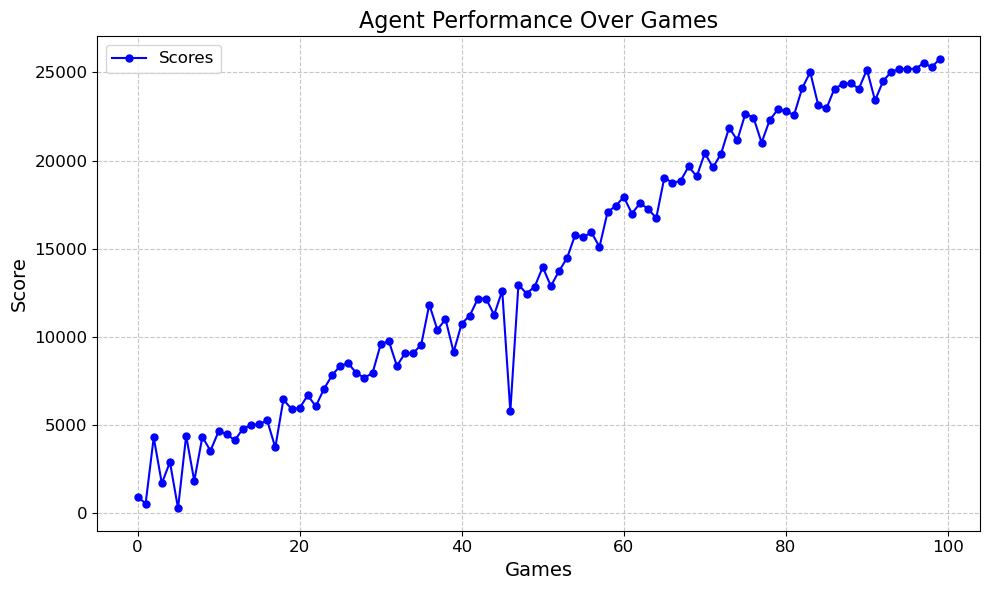

In [25]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.003,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=1e-5,
    n_games=100
)

## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!

Plot the incrementation of your score through n games and try to justify the patterns.

# Report on Manipulating Hyperparameters in Reinforcement Learning

## Introduction
In this experiment, we aimed to explore the effects of various hyperparameters on the performance of a reinforcement learning model. The key hyperparameters manipulated were the number of games, epsilon (and its decay and end values), batch size, and gamma. This report summarizes the observations and their implications on model performance, providing insights into why these effects occur.

## Hyperparameters and Their Effects

### Number of Games
- **Observation:** Decreasing the number of games reduces training time but also results in a slightly worse model performance.
- **Implication:** With fewer episodes, the model has insufficient data to learn effectively, leading to suboptimal policies. Ensuring an adequate number of episodes is critical for robust training because it allows the agent to experience a wide range of states and rewards, fostering better generalization.

### Epsilon (Exploration Rate)
- **Epsilon End:**
  - **Observation:** Increasing the epsilon end value results in more fluctuating and unpredictable rewards.
  - **Implication:** A higher epsilon end value means the model maintains a higher exploration rate towards the end of training, causing more variability in the rewards due to exploring suboptimal actions frequently. This exploration is necessary early in training to discover optimal strategies but should decrease over time to allow the model to exploit learned knowledge.

- **Epsilon Decay:**
  - **Observation:** Decreasing the epsilon decay rate leads to more random results, especially with a small number of games.
  - **Implication:** A slower decay rate prolongs the exploration phase, making the agent take random actions longer. This extended exploration can be beneficial for discovering new strategies, but it needs to be balanced with sufficient training episodes to avoid excessive randomness.

- **Combined Epsilon Adjustments:**
  - **Observation:** Decreasing the epsilon end and increasing the epsilon decay reduces randomness in rewards.
  - **Implication:** This combination balances exploration and exploitation better, leading to more stable learning, provided there are sufficient episodes to leverage the reduced randomness. It ensures the agent explores enough initially but gradually shifts to exploiting the best-known strategies.

### Batch Size
- **Observation:**
  - **Decreasing batch size to 2 resulted in negative rewards.**
  - **Increasing batch size to 8 reduced randomness.**
  - **Batch sizes 16, 32, and 64 produced similar results, with 8 being the most effective.**
- **Implication:** 
  - A very small batch size (e.g., 2) leads to high variance in gradient updates due to insufficient data in each batch, making learning unstable and erratic. Larger batch sizes provide more stable gradient estimates, improving learning efficiency. However, beyond a certain point (e.g., batch sizes 16, 32, 64), the benefits plateau, and the increased computational cost does not yield proportional performance gains. The batch size of 8 strikes a good balance between stability and efficiency.

### Gamma (Discount Factor)
- **Observation:** Decreasing gamma from 0.99 to 0.9 improved results.
- **Implication:** A lower gamma value places more emphasis on immediate rewards rather than long-term rewards. This can lead to better performance in environments where immediate feedback is more indicative of successful strategies. In this case, the agent likely benefited from focusing on short-term gains, leading to better overall performance.

### Epsilon End (Extended Observation)
- **Observation:** Increasing the epsilon end to 0.4 made the dataset very noisy.
- **Implication:** A high epsilon end value means the agent continues to explore significantly even towards the end of training, leading to high variability in the actions and resulting rewards. This excessive exploration can prevent the agent from consistently exploiting the best-known strategies, making the training data noisy and hindering learning stability.

### Decay Rate
- **Observation:** A smaller decay rate improved results.
- **Implication:** A slower decay rate maintains a higher exploration rate for a longer period, encouraging the agent to discover new strategies. This extended exploration phase allows the agent to gather diverse experiences, potentially leading to more robust policies.

## General Observation
- **Randomness in Plots:**
  - Without using a target network for Q-value updates, the learning process becomes unstable, leading to high variability in the results.
  - **Implication:** Implementing a target network can stabilize learning by providing more consistent Q-value targets, reducing the volatility observed in the reward plots. This helps in smoothing the learning updates, leading to more stable and reliable performance.

## Conclusion
The manipulation of hyperparameters in reinforcement learning models significantly affects their performance and stability. Key takeaways include:
1. Ensuring a sufficient number of training episodes is essential for effective learning.
2. Balancing exploration and exploitation through careful tuning of epsilon and its decay can stabilize rewards.
3. Using a moderate batch size (e.g., 8) can improve learning stability and efficiency without incurring unnecessary computational costs.
4. Decreasing gamma to focus on immediate rewards can be beneficial in environments where short-term feedback is more relevant.
5. Implementing a target network for Q-value updates is recommended to further reduce randomness and stabilize training.
6. A smaller epsilon decay rate encourages thorough exploration, potentially leading to better long-term strategies.

By understanding and adjusting these hyperparameters, we can significantly enhance the performance and stability of reinforcement learning models.


## (Bonus) Target Q Network

Instead of calculating the target q-value using the formula presented, you can use anonther Deep Neural Network to predict the target Q-values via regression!

Implementing the target Q network alonside the eval Q network can lead to more steady behavior of the final score.

In [26]:
class AgentWithTargetNetwork(Agent):
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4, tau=0.005):
        super(AgentWithTargetNetwork, self).__init__(gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size, eps_end, eps_dec)
        self.tau = tau
        self.Q_target = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        self.update_target_network(tau=1.0)

    def update_target_network(self, tau=None):
        if tau is None:
            tau = self.tau

        for target_param, eval_param in zip(self.Q_target.parameters(), self.Q_eval.parameters()):
            target_param.data.copy_(tau * eval_param.data + (1 - tau) * target_param.data)

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch], dtype=T.float32).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch], dtype=T.float32).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch], dtype=T.float32).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch], dtype=T.bool).to(self.Q_eval.device)

        with autocast():
            q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
            q_next = self.Q_target.forward(new_state_batch)
            q_next[terminal_batch] = 0.0

            q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]

            loss = self.Q_eval.loss(q_target, q_eval)

        self.scaler.scale(loss).backward()
        self.scaler.step(self.Q_eval.optimizer)
        self.scaler.update()

        self.update_target_network()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        del state_batch, new_state_batch, reward_batch, terminal_batch, q_eval, q_next, q_target
        T.cuda.empty_cache()


In [28]:
def run_experiment(env_path, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                   max_mem_size, eps_end, eps_dec, tau,n_games):
    # Create the maze environment
    env = MazeEnvironment(50, env_path)

    # Initialize the agent
    agent = AgentWithTargetNetwork(gamma=gamma, epsilon=epsilon, lr=lr, input_dims=input_dims,
                                   batch_size=batch_size, n_actions=n_actions, max_mem_size=max_mem_size,
                                   eps_end=eps_end, eps_dec=eps_dec,tau = tau)

    scores, eps_history = [], []

    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        counter = 0
        while not done:
            counter += 1
            # If performed 1000 moves and didn't finish the maze, reset the environment
            if counter == 1000:
                break

            # Make the agent choose an action
            action = agent.choose_action(observation)

            # Retrieve the reward and next_state from the environment
            observation_, reward, done = env.step(action)

            score += reward

            # Store the current episode in the memory
            agent.store_transition(observation, action, reward, observation_, done)

            # Learn the current episode
            agent.learn()

            # Change the next state to the current state
            observation = observation_

        scores.append(score)

        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

    plot_scores(scores, n_games)

episode  0 score 1023.00 average score 1023.00 epsilon 0.99
episode  1 score 908.00 average score 965.50 epsilon 0.98
episode  2 score 1804.00 average score 1245.00 epsilon 0.97
episode  3 score 1560.00 average score 1323.75 epsilon 0.96
episode  4 score 2950.00 average score 1649.00 epsilon 0.95
episode  5 score 2726.00 average score 1828.50 epsilon 0.94
episode  6 score 1437.00 average score 1772.57 epsilon 0.93
episode  7 score 2022.00 average score 1803.75 epsilon 0.92
episode  8 score 2679.00 average score 1901.00 epsilon 0.91
episode  9 score 3649.00 average score 2075.80 epsilon 0.90
episode  10 score 3636.00 average score 2217.64 epsilon 0.89
episode  11 score 4713.00 average score 2425.58 epsilon 0.88
episode  12 score 4115.00 average score 2555.54 epsilon 0.87
episode  13 score 4507.00 average score 2694.93 epsilon 0.86
episode  14 score 3846.00 average score 2771.67 epsilon 0.85
episode  15 score 3917.00 average score 2843.25 epsilon 0.84
episode  16 score 5652.00 average sc

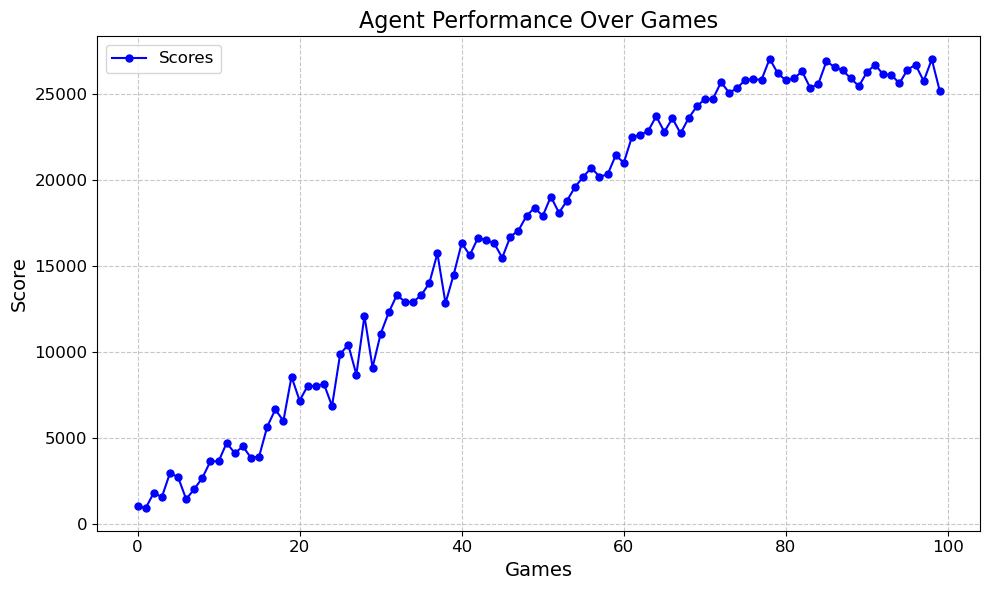

In [29]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.003,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=1e-5,
    n_games=100,
    tau = 0.005
)

episode  0 score 3804.00 average score 3804.00 epsilon 0.99
episode  1 score 572.00 average score 2188.00 epsilon 0.98
episode  2 score 638.00 average score 1671.33 epsilon 0.97
episode  3 score 3085.00 average score 2024.75 epsilon 0.96
episode  4 score 2175.00 average score 2054.80 epsilon 0.95
episode  5 score 724.00 average score 1833.00 epsilon 0.94
episode  6 score 1967.00 average score 1852.14 epsilon 0.93
episode  7 score 2885.00 average score 1981.25 epsilon 0.92
episode  8 score 2772.00 average score 2069.11 epsilon 0.91
episode  9 score 2469.00 average score 2109.10 epsilon 0.90
episode  10 score 4564.00 average score 2332.27 epsilon 0.89
episode  11 score 4979.00 average score 2552.83 epsilon 0.88
episode  12 score 5401.00 average score 2771.92 epsilon 0.87
episode  13 score 7568.00 average score 3114.50 epsilon 0.86
episode  14 score 6071.00 average score 3311.60 epsilon 0.85
episode  15 score 5668.00 average score 3458.88 epsilon 0.84
episode  16 score 6178.00 average sco

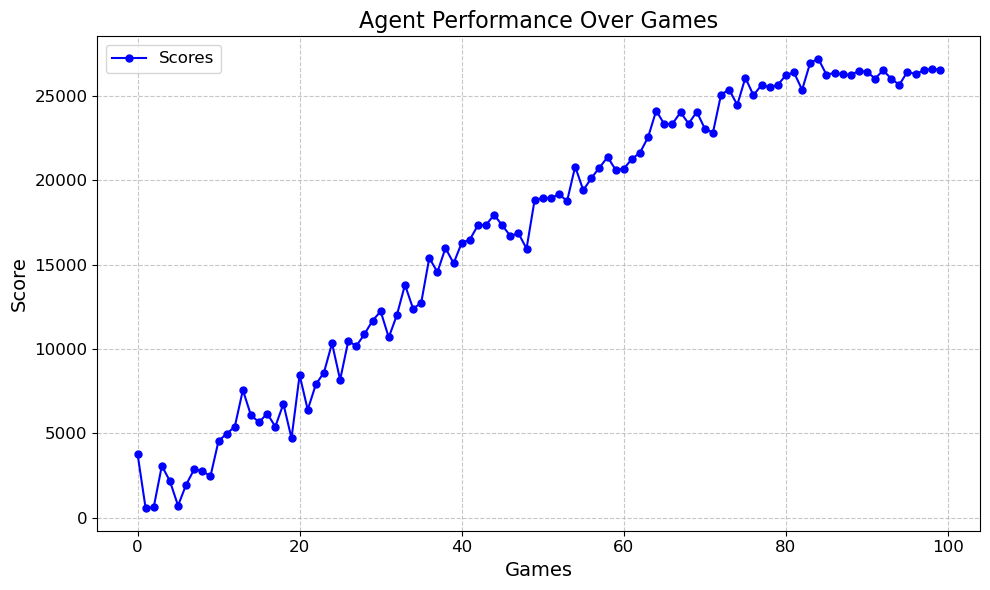

In [30]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.003,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=1e-5,
    n_games=100,
    tau = 0.002
)

episode  0 score 154.00 average score 154.00 epsilon 0.99
episode  1 score 1720.00 average score 937.00 epsilon 0.98
episode  2 score 4388.00 average score 2087.33 epsilon 0.97
episode  3 score 1073.00 average score 1833.75 epsilon 0.96
episode  4 score 2788.00 average score 2024.60 epsilon 0.95
episode  5 score 2040.00 average score 2027.17 epsilon 0.94
episode  6 score 1358.00 average score 1931.57 epsilon 0.93
episode  7 score 4050.00 average score 2196.38 epsilon 0.92
episode  8 score 2048.00 average score 2179.89 epsilon 0.91
episode  9 score 3925.00 average score 2354.40 epsilon 0.90
episode  10 score 3090.00 average score 2421.27 epsilon 0.89
episode  11 score 2981.00 average score 2467.92 epsilon 0.88
episode  12 score 5591.00 average score 2708.15 epsilon 0.87
episode  13 score 3456.00 average score 2761.57 epsilon 0.86
episode  14 score 4389.00 average score 2870.07 epsilon 0.85
episode  15 score 4727.00 average score 2986.12 epsilon 0.84
episode  16 score 5955.00 average sco

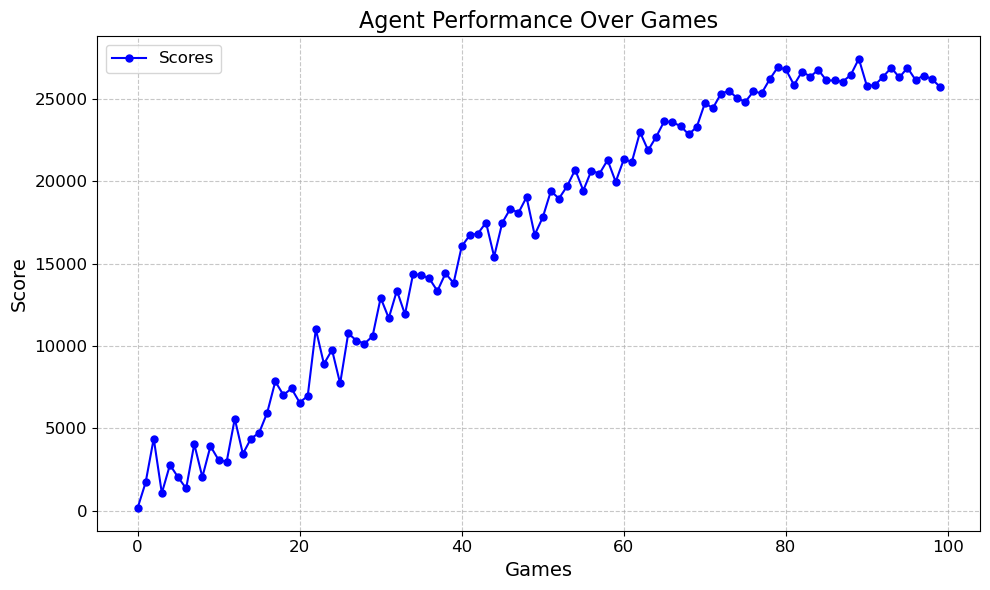

In [31]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.003,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=1e-5,
    n_games=100,
    tau = 0.01
)

episode  0 score 1500.00 average score 1500.00 epsilon 0.99
episode  1 score 523.00 average score 1011.50 epsilon 0.98
episode  2 score 2062.00 average score 1361.67 epsilon 0.97
episode  3 score 1681.00 average score 1441.50 epsilon 0.96
episode  4 score 3406.00 average score 1834.40 epsilon 0.95
episode  5 score 3607.00 average score 2129.83 epsilon 0.94
episode  6 score 3905.00 average score 2383.43 epsilon 0.93
episode  7 score 3943.00 average score 2578.38 epsilon 0.92
episode  8 score 1807.00 average score 2492.67 epsilon 0.91
episode  9 score 5595.00 average score 2802.90 epsilon 0.90
episode  10 score 5356.00 average score 3035.00 epsilon 0.89
episode  11 score 3048.00 average score 3036.08 epsilon 0.88
episode  12 score 3663.00 average score 3084.31 epsilon 0.87
episode  13 score 5462.00 average score 3254.14 epsilon 0.86
episode  14 score 5416.00 average score 3398.27 epsilon 0.85
episode  15 score 4536.00 average score 3469.38 epsilon 0.84
episode  16 score 5073.00 average s

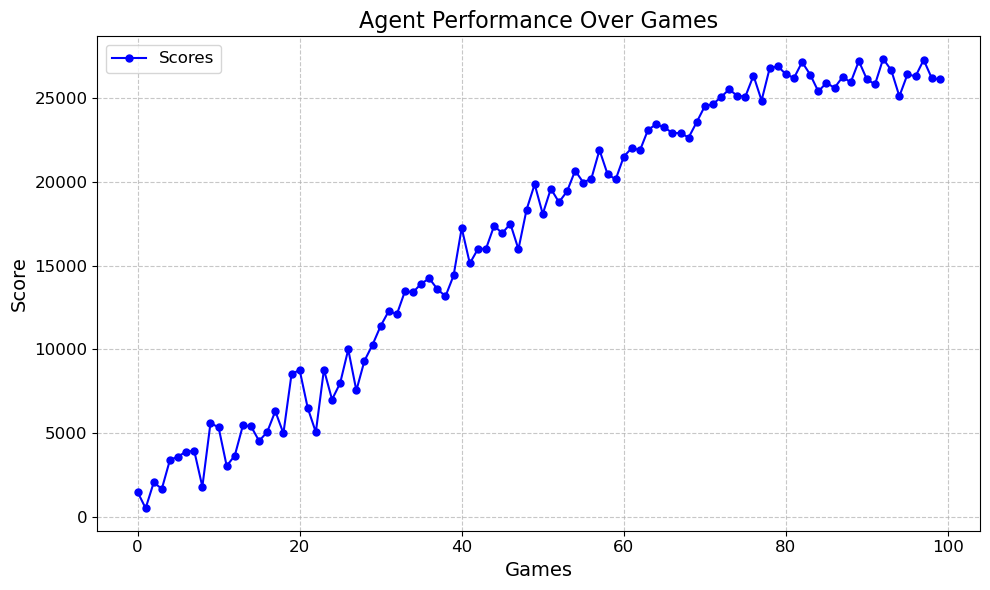

In [32]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.003,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=1e-5,
    n_games=100,
    tau = 0.02
)

episode  0 score 1166.00 average score 1166.00 epsilon 0.99
episode  1 score 2124.00 average score 1645.00 epsilon 0.98
episode  2 score 1559.00 average score 1616.33 epsilon 0.97
episode  3 score 1043.00 average score 1473.00 epsilon 0.96
episode  4 score 1344.00 average score 1447.20 epsilon 0.95
episode  5 score 1214.00 average score 1408.33 epsilon 0.94
episode  6 score 3248.00 average score 1671.14 epsilon 0.93
episode  7 score 2583.00 average score 1785.12 epsilon 0.92
episode  8 score 3058.00 average score 1926.56 epsilon 0.91
episode  9 score 2472.00 average score 1981.10 epsilon 0.90
episode  10 score 2436.00 average score 2022.45 epsilon 0.89
episode  11 score 5037.00 average score 2273.67 epsilon 0.88
episode  12 score 3882.00 average score 2397.38 epsilon 0.87
episode  13 score 4534.00 average score 2550.00 epsilon 0.86
episode  14 score 3953.00 average score 2643.53 epsilon 0.85
episode  15 score 5082.00 average score 2795.94 epsilon 0.84
episode  16 score 4070.00 average 

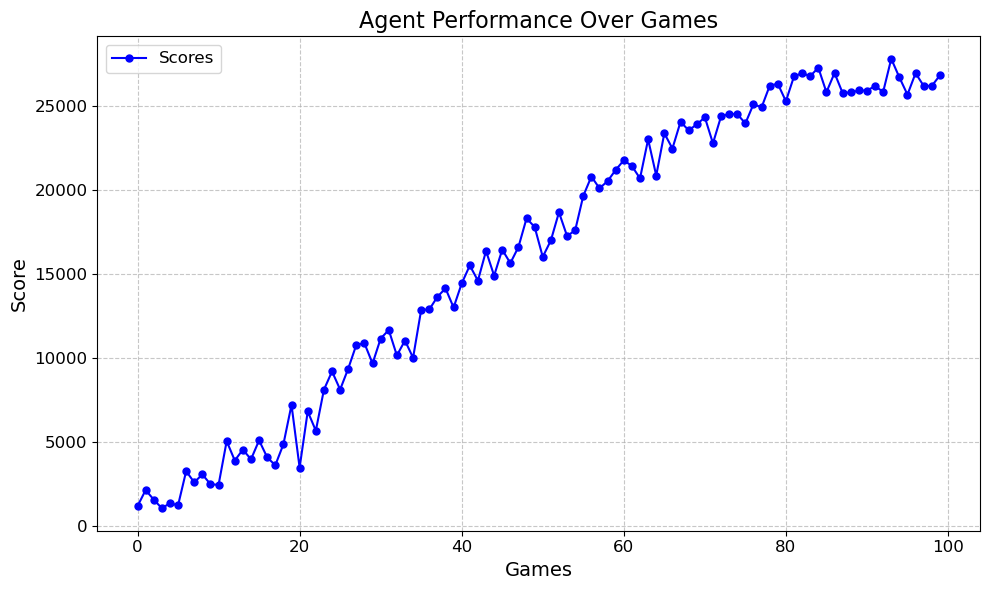

In [33]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.9,
    epsilon=1.0,
    lr=0.003,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=1e-5,
    n_games=100,
    tau = 0.001
)

episode  0 score 565.00 average score 565.00 epsilon 0.99
episode  1 score 556.00 average score 560.50 epsilon 0.98
episode  2 score 1328.00 average score 816.33 epsilon 0.97
episode  3 score 1615.00 average score 1016.00 epsilon 0.96
episode  4 score 2905.00 average score 1393.80 epsilon 0.95
episode  5 score 3493.00 average score 1743.67 epsilon 0.94
episode  6 score 4500.00 average score 2137.43 epsilon 0.93
episode  7 score 3669.00 average score 2328.88 epsilon 0.92
episode  8 score 2252.00 average score 2320.33 epsilon 0.91
episode  9 score 2598.00 average score 2348.10 epsilon 0.90
episode  10 score 3071.00 average score 2413.82 epsilon 0.89
episode  11 score 3097.00 average score 2470.75 epsilon 0.88
episode  12 score 4572.00 average score 2632.38 epsilon 0.87
episode  13 score 2917.00 average score 2652.71 epsilon 0.86
episode  14 score 5550.00 average score 2845.87 epsilon 0.85
episode  15 score 6127.00 average score 3050.94 epsilon 0.84
episode  16 score 4820.00 average score

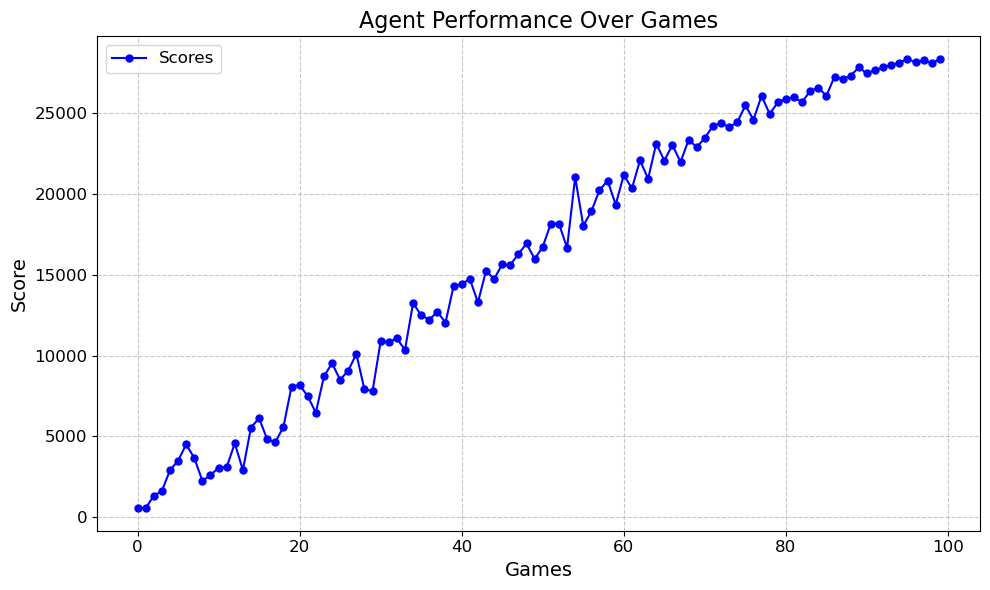

In [34]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.99,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=8,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.1,
    eps_dec=1e-5,
    n_games=100,
    tau= 0.002
)

episode  0 score 1928.00 average score 1928.00 epsilon 0.85
episode  1 score 8032.00 average score 4980.00 epsilon 0.65
episode  2 score 12722.00 average score 7560.67 epsilon 0.45
episode  3 score 16143.00 average score 9706.25 epsilon 0.25
episode  4 score 18584.00 average score 11481.80 epsilon 0.20
episode  5 score 18500.00 average score 12651.50 epsilon 0.20
episode  6 score 18209.00 average score 13445.43 epsilon 0.20
episode  7 score 18785.00 average score 14112.88 epsilon 0.20
episode  8 score 18694.00 average score 14621.89 epsilon 0.20
episode  9 score 18982.00 average score 15057.90 epsilon 0.20
episode  10 score 18565.00 average score 15376.73 epsilon 0.20
episode  11 score 18607.00 average score 15645.92 epsilon 0.20
episode  12 score 18728.00 average score 15883.00 epsilon 0.20
episode  13 score 18609.00 average score 16077.71 epsilon 0.20
episode  14 score 18400.00 average score 16232.53 epsilon 0.20
episode  15 score 18228.00 average score 16357.25 epsilon 0.20
episode 

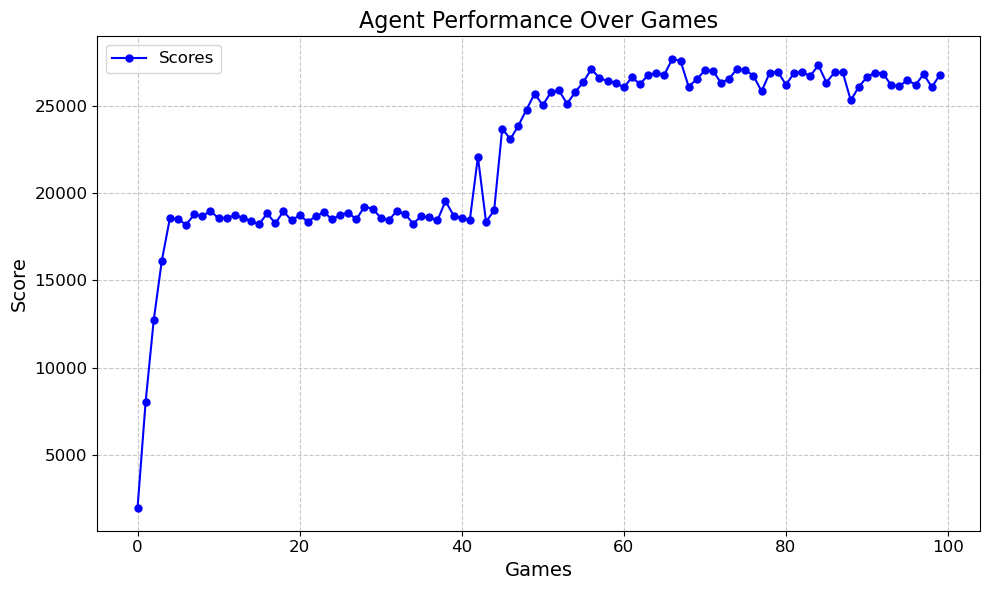

In [35]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.90,
    epsilon=1.0,
    lr=0.001,
    input_dims=[2],
    batch_size=32,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.2,
    eps_dec=2e-4,
    n_games=100,
    tau= 0.05
)

episode  0 score 433.00 average score 433.00 epsilon 0.90
episode  1 score 6233.00 average score 3333.00 epsilon 0.80
episode  2 score 7816.00 average score 4827.33 epsilon 0.70
episode  3 score 9490.00 average score 5993.00 epsilon 0.60
episode  4 score 11141.00 average score 7022.60 epsilon 0.50
episode  5 score 14002.00 average score 8185.83 epsilon 0.40
episode  6 score 14588.00 average score 9100.43 epsilon 0.40
episode  7 score 14286.00 average score 9748.62 epsilon 0.40
episode  8 score 14185.00 average score 10241.56 epsilon 0.40
episode  9 score 15032.00 average score 10720.60 epsilon 0.40
episode  10 score 14280.00 average score 11044.18 epsilon 0.40
episode  11 score 15848.00 average score 11444.50 epsilon 0.40
episode  12 score 14819.00 average score 11704.08 epsilon 0.40
episode  13 score 15331.00 average score 11963.14 epsilon 0.40
episode  14 score 15163.00 average score 12176.47 epsilon 0.40
episode  15 score 14844.00 average score 12343.19 epsilon 0.40
episode  16 scor

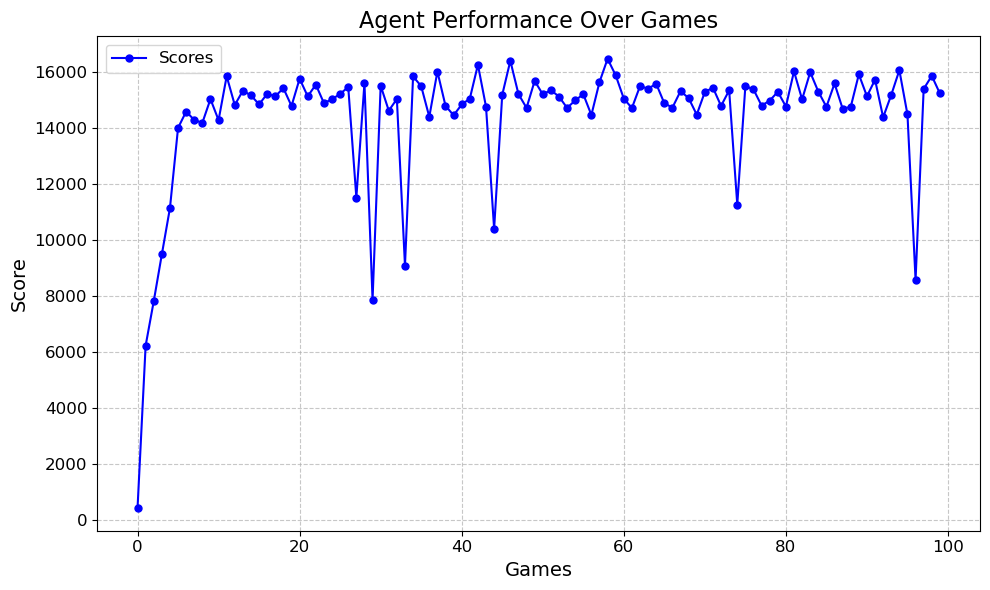

In [37]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.90,
    epsilon=1.0,
    lr=0.005,
    input_dims=[2],
    batch_size=16,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.4,
    eps_dec=1e-4,
    n_games=100,
    tau= 0.1
)

episode  0 score 2095.00 average score 2095.00 epsilon 0.99
episode  1 score 1072.00 average score 1583.50 epsilon 0.98
episode  2 score 1117.00 average score 1428.00 epsilon 0.97
episode  3 score 977.00 average score 1315.25 epsilon 0.96
episode  4 score -837.00 average score 884.80 epsilon 0.95
episode  5 score 1420.00 average score 974.00 epsilon 0.94
episode  6 score 1117.00 average score 994.43 epsilon 0.93
episode  7 score 1681.00 average score 1080.25 epsilon 0.92
episode  8 score 1337.00 average score 1108.78 epsilon 0.91
episode  9 score 3797.00 average score 1377.60 epsilon 0.90
episode  10 score 5049.00 average score 1711.36 epsilon 0.89
episode  11 score 6431.00 average score 2104.67 epsilon 0.88
episode  12 score 4168.00 average score 2263.38 epsilon 0.87
episode  13 score 5608.00 average score 2502.29 epsilon 0.86
episode  14 score 3454.00 average score 2565.73 epsilon 0.85
episode  15 score 4161.00 average score 2665.44 epsilon 0.84
episode  16 score 5250.00 average scor

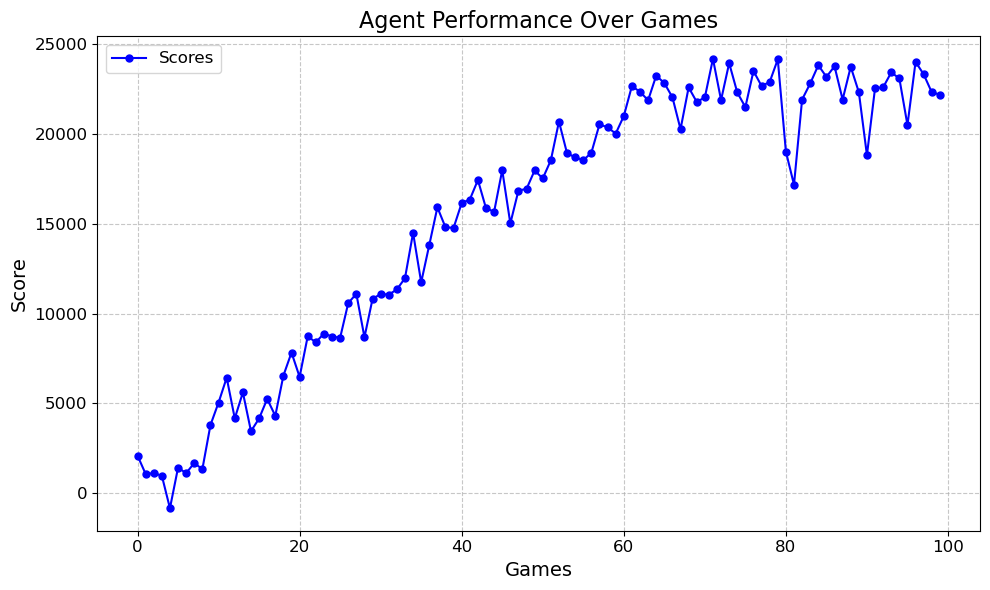

In [38]:
run_experiment(
    env_path='mazes/maze1.npy',
    gamma=0.7,
    epsilon=1.0,
    lr=0.002,
    input_dims=[2],
    batch_size=16,
    n_actions=4,
    max_mem_size=100000,
    eps_end=0.3,
    eps_dec=1e-5,
    n_games=100,
    tau= 0.001
)